In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import seaborn as sns
import scipy as scipy
import matplotlib as matplot
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold


from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.feature_selection import SelectKBest, SelectPercentile
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")

pd.set_option("display.precision", 4)
np.random.seed(2021)

In [2]:
print("numpy:", np.__version__)
print("pandas:", np.__version__)
print("seaborn:", sns.__version__)
print("sklearn:", sk.__version__)
print("matplotlib:", matplot.__version__)
print("scipy:", scipy.__version__)

%matplotlib inline

numpy: 1.20.3
pandas: 1.20.3
seaborn: 0.11.1
sklearn: 0.24.2
matplotlib: 3.4.2
scipy: 1.6.3


In [3]:
signature_original_dataframe = pd.read_csv("signature-dataset.csv")
df = signature_original_dataframe.copy()

In [4]:
def replace_with_mean_per_class(attr):
    attr_mean_per_class = df.loc[:, [attr, 'class']].groupby(by=['class']).mean()
    attr_and_class = df.loc[:, [attr, 'class']]
    attr_and_class[attr] = np.where(attr_and_class['class'] == 'anomaly', 
                                attr_and_class[attr].fillna(attr_mean_per_class.loc['anomaly', attr]),
                                attr_and_class[attr].fillna(attr_mean_per_class.loc['normal', attr]))
    df[attr] = attr_and_class[attr]

In [5]:
_ = replace_with_mean_per_class('count')
_ = replace_with_mean_per_class('srv_count')

In [6]:
df['duration'] = df['duration'].astype('float64')
df['src_bytes'] = df['src_bytes'].astype('float64')
df['dst_bytes'] = df['dst_bytes'].astype('float64')
df['land'] = df['land'].astype('float64')
df['wrong_fragment'] = df['wrong_fragment'].astype('float64')

df['urgent'] = df['urgent'].astype('float64')
df['hot'] = df['hot'].astype('float64')
df['num_failed_logins'] = df['num_failed_logins'].astype('float64')
df['logged_in'] = df['logged_in'].astype('float64')
df['num_compromised'] = df['num_compromised'].astype('float64')

df['root_shell'] = df['root_shell'].astype('float64')
df['su_attempted'] = df['su_attempted'].astype('float64')
df['num_root'] = df['num_root'].astype('float64')
df['num_file_creations'] = df['num_file_creations'].astype('float64')
df['num_shells'] = df['num_shells'].astype('float64')

df['num_access_files'] = df['num_access_files'].astype('float64')
df['is_guest_login'] = df['is_guest_login'].astype('float64')
df['dst_host_count'] = df['dst_host_count'].astype('float64')
df['dst_host_srv_count'] = df['dst_host_srv_count'].astype('float64')

print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22544 entries, 0 to 22543
Data columns (total 40 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   duration                     22544 non-null  float64
 1   protocol_type                22544 non-null  object 
 2   service                      22544 non-null  object 
 3   flag                         22544 non-null  object 
 4   src_bytes                    22544 non-null  float64
 5   dst_bytes                    22544 non-null  float64
 6   land                         22544 non-null  float64
 7   wrong_fragment               22544 non-null  float64
 8   urgent                       22544 non-null  float64
 9   hot                          22544 non-null  float64
 10  num_failed_logins            22544 non-null  float64
 11  logged_in                    22544 non-null  float64
 12  num_compromised              22544 non-null  float64
 13  root_shell      

In [7]:
numerical_features = ['duration',
                      'src_bytes',
                      'dst_bytes',
                      'land',
                      'wrong_fragment',
                      'urgent',
                      'hot',
                      'num_failed_logins',
                      'logged_in',
                      'num_compromised',
                      'root_shell',
                      'su_attempted',
                      'num_root',
                      'num_file_creations',
                      'num_shells',
                      'num_access_files',
                      'is_guest_login',
                      'count',
                      'srv_count',
                      'serror_rate',
                      'srv_serror_rate',
                      'rerror_rate',
                      'srv_rerror_rate',
                      'same_srv_rate',
                      'diff_srv_rate',
                      'srv_diff_host_rate',
                      'dst_host_count',
                      'dst_host_srv_count',
                      'dst_host_same_srv_rate',
                      'dst_host_diff_srv_rate',
                      'dst_host_same_src_port_rate',
                      'dst_host_srv_diff_host_rate',
                      'dst_host_serror_rate',
                      'dst_host_srv_serror_rate',
                      'dst_host_rerror_rate',
                      'dst_host_srv_rerror_rate']

categorical_features = ['protocol_type', 'service', 'flag']

In [8]:
numerical_features_df = df[numerical_features]
#print(numerical_features_df.info())
#print()
categorical_features_df = df[categorical_features]
#print(categorical_features_df.info())

In [9]:
X = df[numerical_features].iloc[:,:]
Y = df[numerical_features].iloc[:, -1]

In [10]:
encoder = LabelEncoder()
Y = encoder.fit_transform(Y)

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.25, random_state = 2021)

In [12]:
X_train.shape, X_test.shape

((16908, 36), (5636, 36))

# Feature Selection

The feature selection can be done using 3 type of methods

1) Filter methods

2) Wrapper methods

3) Embedded methods

## 1) Filter Methods

Filter method can be again divided into 3

a) Removal of constant, quasi-constant and duplicate features

b) Removal of Correlated features

c) Using statistical methods

### a) Removal of constant, quasi-constant and duplicate features

In [13]:
const = VarianceThreshold(threshold=0.01)  

const.fit(X_train)  # fit finds the features with low variance

VarianceThreshold(threshold=0.01)

In [14]:
#the number of quasi-constant features

quasi_constant = X_train.columns[~const.get_support()]

len(quasi_constant)

7

In [15]:
quasi_constant

Index(['land', 'urgent', 'root_shell', 'su_attempted', 'num_shells',
       'num_access_files', 'dst_host_srv_diff_host_rate'],
      dtype='object')

In [16]:
# percentage of observations showing each of the different values
# of the variable

X_train['root_shell'].value_counts() / np.float(len(X_train))

0.0    0.9976
1.0    0.0024
Name: root_shell, dtype: float64

Here more than 99% of the observations show one value, 0. Therefore, this features can be considered as constant.

In [17]:
# storing column names

col_names = X_train.columns[const.get_support()]

In [18]:
#removing the constant and quasi-constant features

X_train = const.transform(X_train)
X_test = const.transform(X_test)

X_train.shape, X_test.shape

((16908, 29), (5636, 29))

In [19]:
# transform the array into a dataframe

X_train = pd.DataFrame(X_train, columns=col_names)
X_test = pd.DataFrame(X_test, columns=col_names)

X_test.head()

,duration,src_bytes,dst_bytes,wrong_fragment,hot,num_failed_logins,logged_in,num_compromised,num_root,num_file_creations,...,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,142.0,1.00,0.00,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,255.0,5.0,0.02,0.17,0.0,1.0,1.0,0.0,0.0
2,31.0,197.0,1608.0,0.0,1.0,0.0,1.0,1.0,1.0,2.0,...,0.0,248.0,32.0,0.13,0.03,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,255.0,1.0,0.00,0.07,0.0,0.0,0.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,255.0,9.0,0.04,0.06,0.0,0.0,0.0,1.0,1.0


As there are no features found as duplicates we can skip that step

### b) Removal of Correlated Features

<AxesSubplot:>

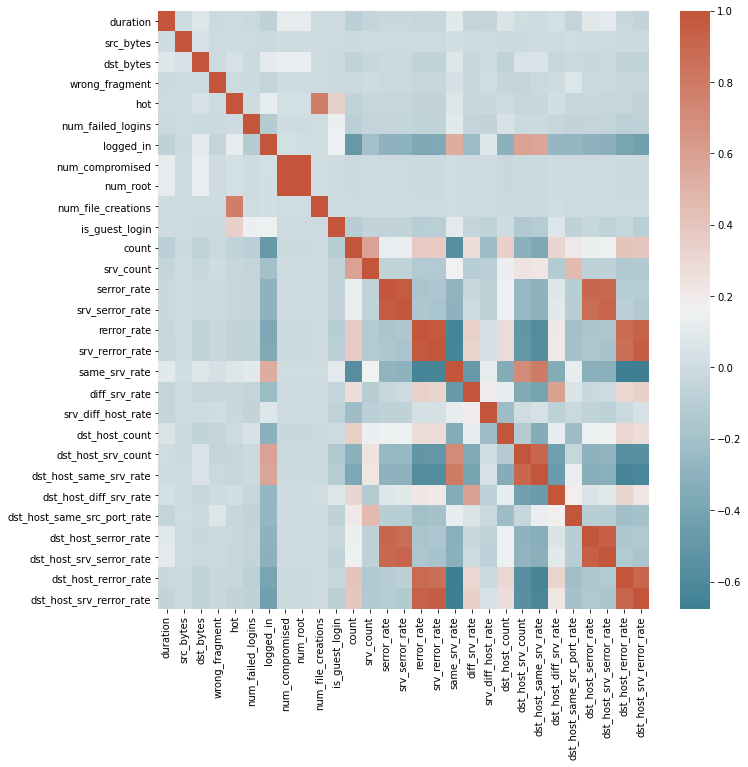

In [20]:
# creating the correlation heat map

corr_matrix = X_train.corr(method='pearson')
corr_map = sns.diverging_palette(220, 20, as_cmap=True)

# some more parameters for the figure
fig, ax = plt.subplots()
fig.set_size_inches(11,11)

# and now plot the correlation matrix
sns.heatmap(corr_matrix, cmap=corr_map)

In [21]:
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                print(abs(corr_matrix.iloc[i, j]), corr_matrix.columns[i], corr_matrix.columns[j])
                colname = corr_matrix.columns[j]
                col_corr.add(colname)
                
    return col_corr

In [22]:
corr_columns = correlation(X_train, 0.8)
len(set(corr_columns))

0.996333194456031 num_root num_compromised
0.9658984257894075 srv_serror_rate serror_rate
0.975128818365034 srv_rerror_rate rerror_rate
0.906867605901658 dst_host_same_srv_rate dst_host_srv_count
0.9040409539321193 dst_host_serror_rate serror_rate
0.8712608552759973 dst_host_serror_rate srv_serror_rate
0.9002451100642666 dst_host_srv_serror_rate serror_rate
0.9206662753379424 dst_host_srv_serror_rate srv_serror_rate
0.9447008767589788 dst_host_srv_serror_rate dst_host_serror_rate
0.8758071023020672 dst_host_rerror_rate rerror_rate
0.8586836391492472 dst_host_rerror_rate srv_rerror_rate
0.931118305733183 dst_host_srv_rerror_rate rerror_rate
0.9483418273421169 dst_host_srv_rerror_rate srv_rerror_rate
0.903259184129262 dst_host_srv_rerror_rate dst_host_rerror_rate


8

In [23]:
corr_columns

{'dst_host_rerror_rate',
 'dst_host_serror_rate',
 'dst_host_srv_count',
 'num_compromised',
 'rerror_rate',
 'serror_rate',
 'srv_rerror_rate',
 'srv_serror_rate'}

In [24]:
X_train.drop(labels=corr_columns, axis=1, inplace=True)
X_test.drop(labels=corr_columns, axis=1, inplace=True)

X_train.shape, X_test.shape

((16908, 21), (5636, 21))

### c) Using statistical methods

The main statistical methods used are Mutual Information , Chi- square and anova

In [25]:
#Mutual Information

mutual_info = mutual_info_classif(X_train, Y_train)
mutual_info


array([0.13048267, 0.50217074, 0.43064676, 0.        , 0.0333855 ,
       0.04292279, 0.13243839, 0.        , 0.        , 0.00696167,
       0.29161799, 0.12801018, 0.30031475, 0.30658167, 0.08970804,
       0.10502375, 0.39919451, 0.35477856, 0.12590174, 0.20495373,
       1.37792435])

Text(0, 0.5, 'Mutual Information')

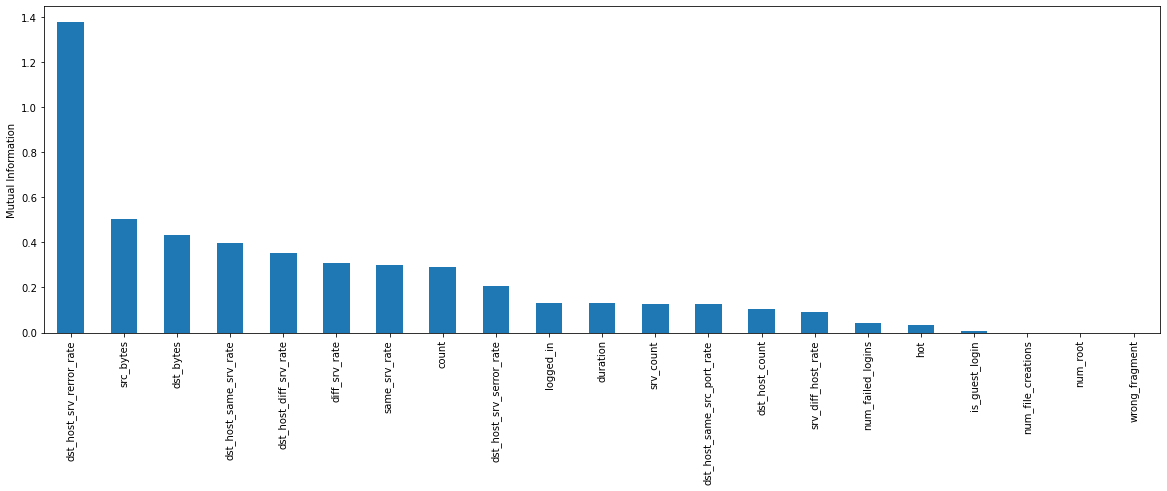

In [26]:
mutual_info = pd.Series(mutual_info)
mutual_info.index = X_train.columns
mutual_info.sort_values(ascending=False).plot.bar(figsize=(20, 6))
plt.ylabel('Mutual Information')

These features are contributing the most towards the target variable based on Mutual Information

In [27]:
"""
sel_ = SelectKBest(mutual_info_classif, k=3).fit(X_train, Y_train)
X_train.columns[sel_.get_support()]
"""

'\nsel_ = SelectKBest(mutual_info_classif, k=3).fit(X_train, Y_train)\nX_train.columns[sel_.get_support()]\n'

In [28]:
# to remove the rest of the features:
"""
X_train = sel_.transform(X_train)
X_test = sel_.transform(X_test)
"""

'\nX_train = sel_.transform(X_train)\nX_test = sel_.transform(X_test)\n'

## Wrapper methods

The wrapper methhods are divided into 3

1) Step forward feature selection

2) Step backwards feature selection

3) Exhaustive feature selection



In [30]:
"""
from mlxtend.feature_selection import ExhaustiveFeatureSelector
           
# import the algorithm you want to evaluate on your features.
from sklearn.ensemble import RandomForestClassifier

# create the ExhaustiveFeatureSelector object.
efs = ExhaustiveFeatureSelector(RandomForestClassifier(), 
           min_features=1,
           max_features=3, 
           scoring='roc_auc',
           cv=2)

# fit the object to the training data.
efs = efs.fit(X_train, Y_train)

# print the selected features.
selected_features = x_train.columns[list(efs.k_feature_idx_)]
print(selected_features)

# print the final prediction score.
print(efs.k_score_)

# transform our data to the newly selected features.
x_train_sfs = efs.transform(x_train)
x_test_sfs = efs.transform(x_test)

"""

"\nfrom mlxtend.feature_selection import ExhaustiveFeatureSelector\n           \n# import the algorithm you want to evaluate on your features.\nfrom sklearn.ensemble import RandomForestClassifier\n\n# create the ExhaustiveFeatureSelector object.\nefs = ExhaustiveFeatureSelector(RandomForestClassifier(), \n           min_features=1,\n           max_features=3, \n           scoring='roc_auc',\n           cv=2)\n\n# fit the object to the training data.\nefs = efs.fit(X_train, Y_train)\n\n# print the selected features.\nselected_features = x_train.columns[list(efs.k_feature_idx_)]\nprint(selected_features)\n\n# print the final prediction score.\nprint(efs.k_score_)\n\n# transform our data to the newly selected features.\nx_train_sfs = efs.transform(x_train)\nx_test_sfs = efs.transform(x_test)\n\n"

In [33]:
dt_classifier = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
dt_classifier.fit(X_train, Y_train)
Y_pred = dt_classifier.predict(X_test)
cm = confusion_matrix(Y_test, Y_pred)

dt_model_accuracy = (100 * (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]))
print("Decision Tree Model Accuracy:", dt_model_accuracy)

dt_cv_accuracies = cross_val_score(estimator = dt_classifier, 
                                    X = X, 
                                    y = Y, 
                                    cv = 10, 
                                    scoring = 'accuracy')

dt_cv_accuracies_mean = (dt_cv_accuracies.mean() * 100)
dt_cv_accuracies_std = (dt_cv_accuracies.std() * 100)

print("Decision Tree Cross Validation Accuracy: {:.2f} %".format(dt_cv_accuracies_mean))
print("Decision Tree Cross Validation Standard-Deviation: {:.2f} %".format(dt_cv_accuracies_std))
print()
# generate_roc_curves(dt_classifier)

Decision Tree Model Accuracy: 100.0
Decision Tree Cross Validation Accuracy: 100.00 %
Decision Tree Cross Validation Standard-Deviation: 0.00 %



In [37]:
clf = svm.SVC()
clf.fit(X_train,Y_train)
Y_pred = clf.predict(X_test)

In [38]:
from sklearn.metrics import classification_report, confusion_matrix
#print(confusion_matrix(Y_test,Y_pred))
print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.68      1.00      0.81      3858
           1       0.00      0.00      0.00       112
           2       0.00      0.00      0.00        64
           3       0.00      0.00      0.00        59
           4       0.00      0.00      0.00        23
           5       0.00      0.00      0.00        19
           6       0.00      0.00      0.00        35
           7       0.00      0.00      0.00        27
           8       0.00      0.00      0.00        16
           9       0.00      0.00      0.00         5
          10       0.00      0.00      0.00         1
          11       0.00      0.00      0.00         6
          12       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         7
          14       0.00      0.00      0.00         4
          15       0.00      0.00      0.00         6
          16       0.00      0.00      0.00         7
          17       0.00    

In [ ]:
X_train[0]